In [1]:
import json
import requests
from bcb import sgs
import streamlit as st

import pandas as pd
import numpy as np
import pytz
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [2]:
data = str(datetime.now(pytz.utc) - timedelta(days = 365 * 3)).replace(' ', 'T')[:-9] + 'Z'

inicio = str(datetime.now(pytz.utc) - timedelta(days = 365 * 12)).replace(' ', 'T')[:-9] + 'Z'

path = "C:/Users/Samsung/Downloads/Dados_Trabalho_Guilherme_Esthevão.xlsx" # mudar para o seu path

cookies = {
    'JSESSIONID': '60B4B40FA7B2A1CD55214842E55D8837',
    'TS019de354': '012e4f88b3a43e52ddd5b616df44d08215f297c1b4cf4c3f733b12f026a39807b652ef8cf837c00d9e40de92225f748edad22f9a7fcfe414c6f45923b4e8b8add1b536ea8992dbbda2475ad34475e460f09303dc636c224ce243177539508c773eb2ee970c',
    '_ga': 'GA1.3.1735499552.1658926079',
    'TS01d9825e': '012e4f88b367dfed413f77c5a8341735f43cece569d51719cb509d994ee4dff815c1f9899412395063ab56e1916893f64f6bcc429e',
    'dtCookie': 'E05B27B3BF49C12A9205D845195ED494|ZXhwZWN0YXRpdmFzfDF8X2RlZmF1bHR8MQ',
    '42d27f55b67981a552aa7b9741398e0b': '8da72a201c033a7780e3e26c420e80d0',
    'cookie_p': '!ZN4nS0u3DYLoOwZolmBKoYk9+3YRD6H+1zlD/akCXEtlcU1IS1MVCoP1DKf4Yv0oOHr8IGsp6Ck4gZU=',
    'TS012aafe5': '012e4f88b3f1dbfc763e900295ea42ab342e8b8842cf4c3f733b12f026a39807b652ef8cf837c00d9e40de92225f748edad22f9a7fcfe414c6f45923b4e8b8add1b536ea896ce13123c24d684ab7e332388d1ad7a6',
}

headers = {
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.9,pt;q=0.8',
    'Connection': 'keep-alive',
    'Content-Type': 'application/json',
    # 'Cookie': 'JSESSIONID=60B4B40FA7B2A1CD55214842E55D8837; TS019de354=012e4f88b3a43e52ddd5b616df44d08215f297c1b4cf4c3f733b12f026a39807b652ef8cf837c00d9e40de92225f748edad22f9a7fcfe414c6f45923b4e8b8add1b536ea8992dbbda2475ad34475e460f09303dc636c224ce243177539508c773eb2ee970c; _ga=GA1.3.1735499552.1658926079; TS01d9825e=012e4f88b367dfed413f77c5a8341735f43cece569d51719cb509d994ee4dff815c1f9899412395063ab56e1916893f64f6bcc429e; dtCookie=E05B27B3BF49C12A9205D845195ED494|ZXhwZWN0YXRpdmFzfDF8X2RlZmF1bHR8MQ; 42d27f55b67981a552aa7b9741398e0b=8da72a201c033a7780e3e26c420e80d0; cookie_p=!ZN4nS0u3DYLoOwZolmBKoYk9+3YRD6H+1zlD/akCXEtlcU1IS1MVCoP1DKf4Yv0oOHr8IGsp6Ck4gZU=; TS012aafe5=012e4f88b3f1dbfc763e900295ea42ab342e8b8842cf4c3f733b12f026a39807b652ef8cf837c00d9e40de92225f748edad22f9a7fcfe414c6f45923b4e8b8add1b536ea896ce13123c24d684ab7e332388d1ad7a6',
    'Origin': 'https://www3.bcb.gov.br',
    'Referer': 'https://www3.bcb.gov.br/expectativas2/',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-origin',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Not?A_Brand";v="8", "Chromium";v="108", "Google Chrome";v="108"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
}

## Obtenção de Dados

### Dados de Expectativas

In [3]:
lista = ()

for i, j, k, foward in zip(("PIB_TOTAL", "IPCA", "TAXA_CAMBIO"),
                   ("ATIVIDADE_GRUPO", "INDICE_PRECOS_GRUPO", "TAXAS_GRUPO"),
                   ("TRIMESTRAL", "MENSAL", "MENSAL"),
                   (2, 4, 4)): # Períodos a frente de PIB, IPCA e Câmbio respectivamente
    
    for b in ["valorMediana", "valorMinimo", "valorMaximo", "valorMedia"]:
    
        json_data = {'dataInicio': '2011-02-04T13:55:14.140Z', 'dataFim': '2020-02-02T13:55:14.140Z', "periodo": k,
                     "consultaIndicadoresDescontinuados": False, "grupoIndicador": j,
                     "codigosIndicadores": [i], "tipoEstatistica": "MEDIANA", "baseCalculoEstatistica": "TRINTA_DIAS"
        }

        response = requests.post('https://www3.bcb.gov.br/expectativas2/rest/publico/consultarSeriesDeEstatisticas',
                                 cookies = cookies, headers = headers, json = json_data)

        df_list = []

        for year in range(len(json.loads(response.content)[0]["detalhes"])):
            for row in pd.json_normalize(json.loads(response.content)[0]["detalhes"][year]["estatisticasPorData"]).iterrows():
                df_list.append(pd.json_normalize(row[1]['estatisticas']))

        df = pd.concat(df_list)[["data", b, "periodoReferencia.descricaoEmIngles"]]

        df['data'] = df['data'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

        if i != "PIB_TOTAL":
            df['dataref'] = df['periodoReferencia.descricaoEmIngles'].apply(lambda x : datetime.strptime(x, '%b/%Y'))
        else:
            df['dataref'] = df['periodoReferencia.descricaoEmIngles'].apply(lambda x: datetime.strptime(x.replace("1Q", "01").\
                                                                            replace("2Q", "04").replace("3Q", "07").\
                                                                            replace("4Q", "10"), '%m/%Y'))

        df = df.sort_values("periodoReferencia.descricaoEmIngles").pivot_table(index = 'data', columns = 'dataref', 
                                                                    values = b, aggfunc = max, fill_value = 0)
        
        df = df.groupby(df.index.to_period("M")).mean()
        df.columns = df.columns.to_period("M")
        
        if i != "PIB_TOTAL":
            df = df.filter(df.columns - foward, axis = 0).filter(df.index + foward, axis = 1)
        else:
            df = df.filter(df.columns - 4*foward, axis = 0).filter(df.index, axis = 1)
            
        df = pd.DataFrame(np.diag(df), index = df.columns)

        lista = lista + (df, )

pib_med, pib_min, pib_max, pib_media, ipca_med, ipca_min, ipca_max, ipca_media, cambio_med, cambio_min, cambio_max, cambio_media = lista

### Dados reais

In [4]:
gdp = sgs.get({"GDP": 22099}, start = datetime.strptime(str(pib_med.index[0] - 3), "%Y-%m"),
              end = datetime.strptime(str(pib_med.index[-1]), "%Y-%m"))
inflation = sgs.get({"IPCA": 433}, start = datetime.strptime(str(ipca_med.index[0]), "%Y-%m"),
               end = datetime.strptime(str(ipca_med.index[-1]), "%Y-%m"))
exrate = sgs.get({"ExRate": 1}, start = datetime.strptime(str(cambio_med.index[0]), "%Y-%m"),
                 end = datetime.strptime(str(cambio_med.index[-1]), "%Y-%m"))

gdp = 100*(gdp/gdp.shift(1) - 1).dropna()

gdp.index = gdp.index.to_period("M")
inflation.index = inflation.index.to_period("M")
exrate = exrate.groupby(exrate.index.to_period("M")).mean()

In [5]:
pib = pd.concat([gdp, pib_med, pib_min, pib_max, pib_media], axis = 1)
ipca = pd.concat([inflation, ipca_med, ipca_min, ipca_max, ipca_media], axis = 1)
cambio = pd.concat([exrate, cambio_med, cambio_min, cambio_max, cambio_media], axis = 1).dropna()

pib.columns = ["Observado", "Mediana", "Minimo", "Maximo", "Média"]
ipca.columns = ["Observado", "Mediana", "Minimo", "Maximo", "Média"]
cambio.columns = ["Observado", "Mediana", "Minimo", "Maximo", "Média"]
pib.index = pib.index.to_timestamp()
ipca.index = ipca.index.to_timestamp()
cambio.index = cambio.index.to_timestamp()

## Gráfico das séries

[Text(0.5, 1.0, 'Câmbio')]

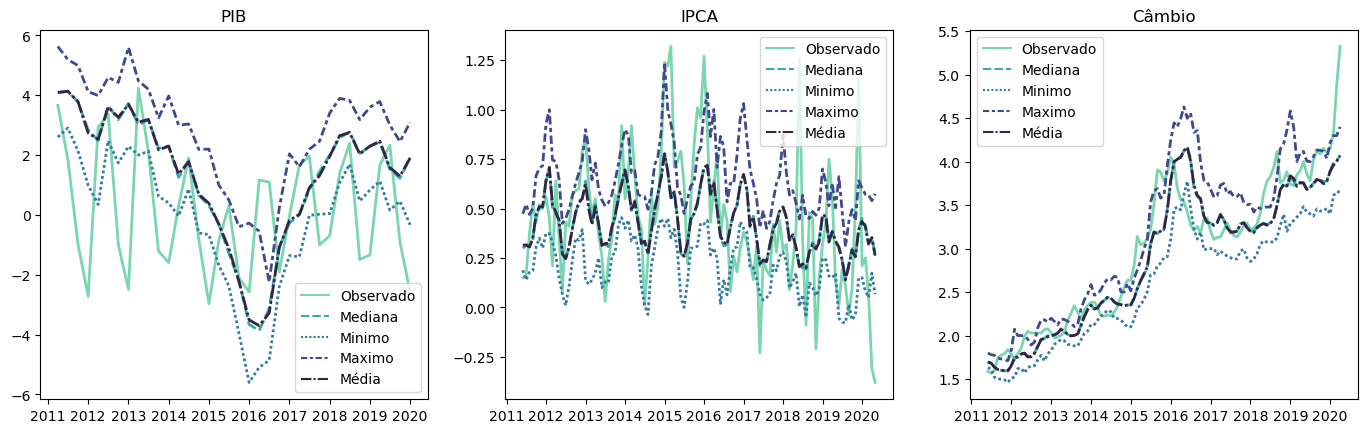

In [6]:
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(17)
sns.lineplot(data = pib, ax = ax[0], palette = sns.color_palette("mako_r", 5), linewidth = 2).set(title = 'PIB')
sns.lineplot(data = ipca, ax = ax[1], palette = sns.color_palette("mako_r", 5), linewidth = 2).set(title = 'IPCA')
sns.lineplot(data = cambio, ax = ax[2], palette = sns.color_palette("mako_r", 5), linewidth = 2).set(title = 'Câmbio')

[Text(0.5, 1.0, 'Câmbio')]

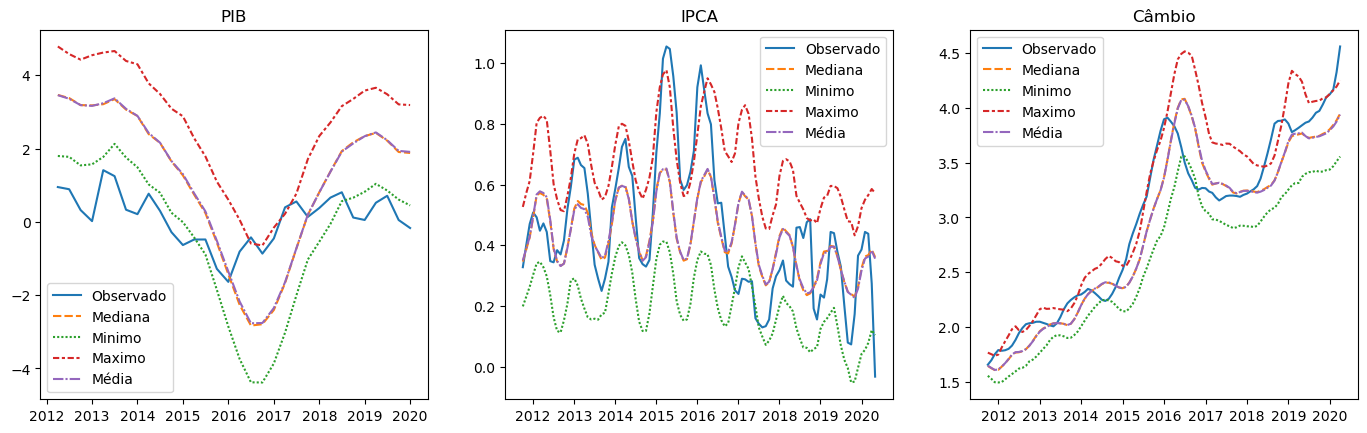

In [7]:
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(17)
sns.lineplot(data = pib.rolling(5).mean(), ax = ax[0]).set(title = 'PIB')
sns.lineplot(data = ipca.rolling(5).mean(), ax = ax[1]).set(title = 'IPCA')
sns.lineplot(data = cambio.rolling(5).mean(), ax = ax[2]).set(title = 'Câmbio')

[Text(0.5, 1.0, 'Câmbio')]

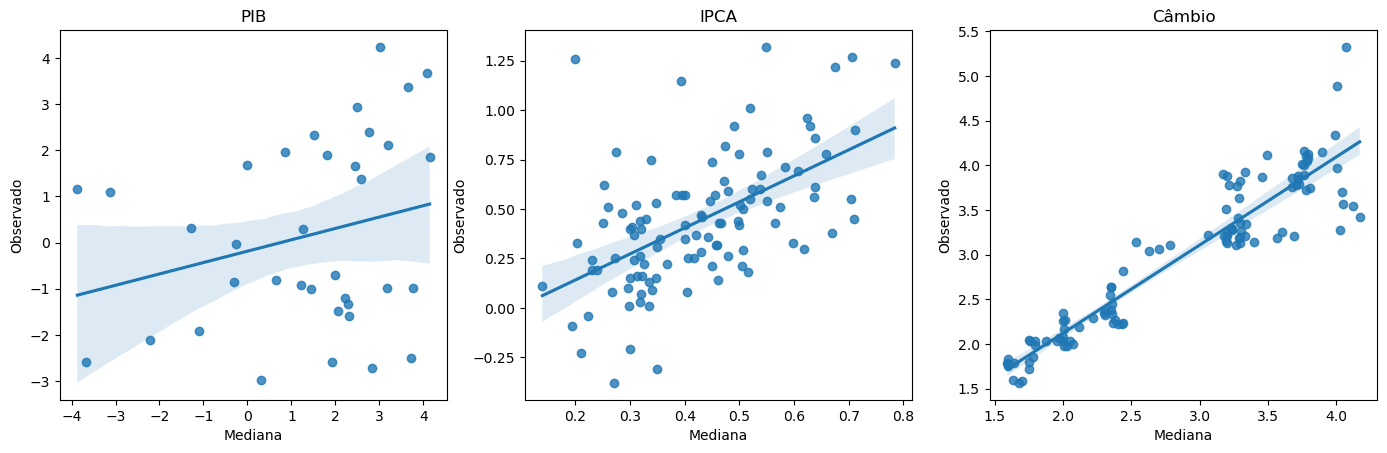

In [8]:
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(17)
sns.regplot(data = pib, x = "Mediana", y = "Observado", ax = ax[0]).set(title = 'PIB')
sns.regplot(data = ipca, x = "Mediana", y = "Observado", ax = ax[1]).set(title = 'IPCA')
sns.regplot(data = cambio, x = "Mediana", y = "Observado", ax = ax[2]).set(title = 'Câmbio')

[Text(0.5, 1.0, 'Câmbio')]

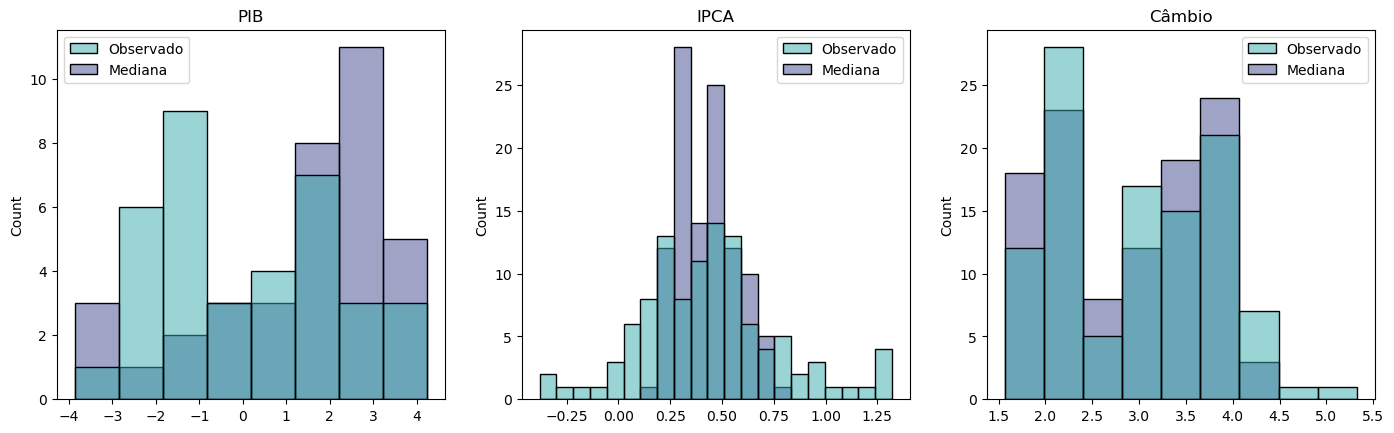

In [9]:
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(17)
sns.histplot(data = pib[["Observado", "Mediana"]], palette = sns.color_palette("mako_r", 2), ax = ax[0]).set(title = 'PIB')
sns.histplot(data = ipca[["Observado", "Mediana"]], palette = sns.color_palette("mako_r", 2), ax = ax[1]).set(title = 'IPCA')
sns.histplot(data = cambio[["Observado", "Mediana"]], palette = sns.color_palette("mako_r", 2), ax = ax[2]).set(title = 'Câmbio')

## Análise Descritiva

In [10]:
correl = pd.concat([pib.corr().filter(["Observado"], axis = 0),
                   ipca.corr().filter(["Observado"], axis = 0),
                   cambio.corr().filter(["Observado"], axis = 0)], axis = 0)

correl.index = ["PIB", "IPCA", "Câmbio"]
correl[correl.columns[1:]].apply(lambda x: x.apply(lambda x: str(round(100*x, 2)) + "%"))

,Mediana,Minimo,Maximo,Média
PIB,25.96%,31.5%,24.2%,26.63%
IPCA,55.58%,53.02%,53.45%,55.94%
Câmbio,93.47%,93.59%,91.92%,93.4%


## Machine Learning

In [11]:
pibx_train, pibx_test, piby_train, piby_test = train_test_split(pib[["Mediana", "Minimo", "Maximo", "Maximo", "Média"]],
                                                                pib["Observado"], test_size = 0.33)

ipcax_train, ipcax_test, ipcay_train, ipcay_test = train_test_split(ipca[["Mediana", "Minimo", "Maximo", "Maximo", "Média"]],
                                                                    ipca["Observado"], test_size = 0.33)

cambiox_train, cambiox_test, cambioy_train, cambioy_test = train_test_split(cambio[["Mediana", "Minimo", "Maximo", "Maximo", "Média"]],
                                                                            cambio["Observado"], test_size = 0.33)

In [12]:
pibx_train_int = sm.add_constant(pibx_train["Minimo"])
pibx_test_int = sm.add_constant(pibx_test["Minimo"])
regpib = sm.OLS(piby_train, pibx_train_int).fit()

print(regpib.summary())

                            OLS Regression Results                            
Dep. Variable:              Observado   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.834
Date:                Mon, 06 Feb 2023   Prob (F-statistic):              0.189
Time:                        19:06:15   Log-Likelihood:                -50.914
No. Observations:                  24   AIC:                             105.8
Df Residuals:                      22   BIC:                             108.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1759      0.431     -0.408      0.6

In [13]:
ipcax_train_int = sm.add_constant(ipcax_train["Média"])
ipcax_test_int = sm.add_constant(ipcax_test["Média"])
regipca = sm.OLS(ipcay_train, ipcax_train_int).fit()

print(regipca.summary())

                            OLS Regression Results                            
Dep. Variable:              Observado   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     27.49
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           1.60e-06
Time:                        19:06:15   Log-Likelihood:                -10.980
No. Observations:                  72   AIC:                             25.96
Df Residuals:                      70   BIC:                             30.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0701      0.113     -0.622      0.5

In [14]:
cambiox_train_int = sm.add_constant(cambiox_train["Mediana"])
cambiox_test_int = sm.add_constant(cambiox_test["Média"])
regcambio = sm.OLS(cambioy_train, cambiox_train_int).fit()

print(regcambio.summary())

                            OLS Regression Results                            
Dep. Variable:              Observado   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     427.7
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           2.73e-31
Time:                        19:06:15   Log-Likelihood:                -18.160
No. Observations:                  71   AIC:                             40.32
Df Residuals:                      69   BIC:                             44.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1772      0.142      1.246      0.2

[Text(0.5, 1.0, 'Câmbio')]

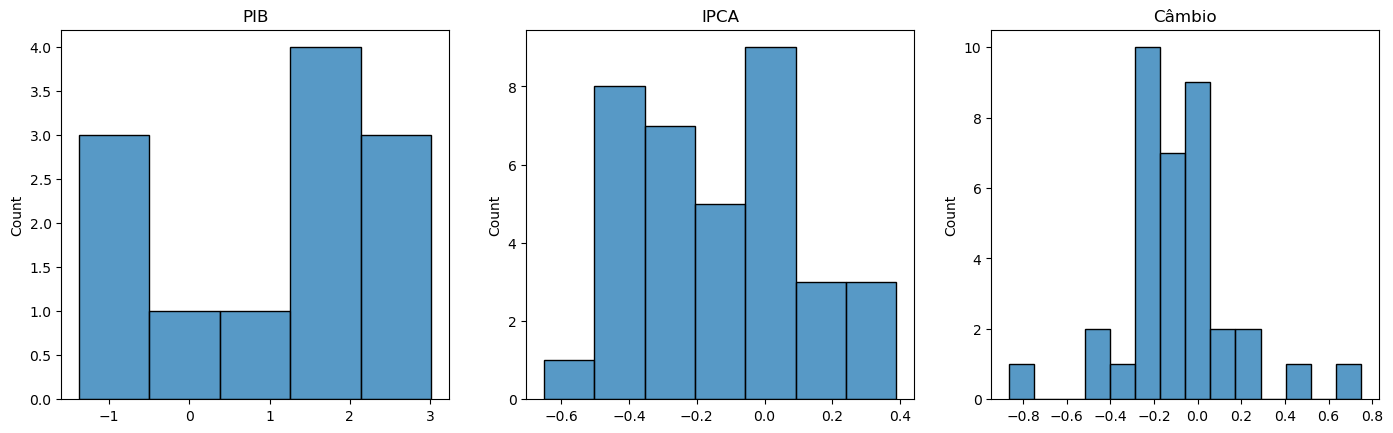

In [15]:
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(17)

sns.histplot(data = piby_test - regpib.predict(pibx_test_int), palette = sns.color_palette("mako_r", 2),
             ax = ax[0]).set(title = 'PIB')
sns.histplot(data = ipcay_test - regipca.predict(ipcax_test_int), palette = sns.color_palette("mako_r", 2),
             ax = ax[1]).set(title = 'IPCA')
sns.histplot(data = cambioy_test - regcambio.predict(cambiox_test_int), palette = sns.color_palette("mako_r", 2),
             ax = ax[2]).set(title = 'Câmbio')

In [16]:
testes = pd.concat([pd.DataFrame([metrics.mean_absolute_error(piby_test, regpib.predict(pibx_test_int)),
                                  metrics.mean_squared_error(piby_test, regpib.predict(pibx_test_int))**0.5,
                                  metrics.r2_score(piby_test, regpib.predict(pibx_test_int))]),
                    pd.DataFrame([metrics.mean_absolute_error(ipcay_test, regipca.predict(cambiox_test_int)),
                                  metrics.mean_squared_error(ipcay_test, regipca.predict(cambiox_test_int))**0.5,
                                  metrics.r2_score(ipcay_test, regipca.predict(cambiox_test_int))]),
                    pd.DataFrame([metrics.mean_absolute_error(cambioy_test, regcambio.predict(ipcax_test_int)),
                                  metrics.mean_squared_error(cambioy_test, regcambio.predict(ipcax_test_int))**0.5,
                                  metrics.r2_score(cambioy_test, regcambio.predict(ipcax_test_int))])], axis = 1)

testes.index = ["MAE", "RMSE", "R²"]
testes.columns = ["PIB", "IPCA", "Câmbio"]
testes

,PIB,IPCA,Câmbio
MAE,1.583899,3.362558,2.346197
RMSE,1.752237,3.545359,2.506331
R²,-0.116850,-137.107085,-7.689952


In [18]:
scaler = StandardScaler()
pib_train_nn = scaler.fit_transform(pibx_train[["Minimo"]])
pib_test_nn = scaler.fit_transform(pibx_test[["Minimo"]])
ipca_train_nn = scaler.fit_transform(ipcax_train[["Média"]])
ipca_test_nn = scaler.fit_transform(ipcax_test[["Média"]])
cambio_train_nn = scaler.fit_transform(cambiox_train[["Mediana"]])
cambio_test_nn = scaler.fit_transform(cambiox_test[["Mediana"]])

model = MLPRegressor(hidden_layer_sizes=(64, 64,64), 
                     activation="relu" ,
                     random_state=42, max_iter=2000)

model.fit(pib_train_nn, piby_train)
pib_pred = pd.DataFrame(model.predict(pib_test_nn), index = pibx_test.index, columns = ["Predito"])

model = MLPRegressor(hidden_layer_sizes=(64, 64,64), 
                     activation="relu" ,
                     random_state=42, max_iter=2000)

model.fit(ipca_train_nn, ipcay_train)
ipca_pred = pd.DataFrame(model.predict(ipca_test_nn), index = ipcax_test.index, columns = ["Predito"])

model = MLPRegressor(hidden_layer_sizes=(64, 64,64), 
                     activation="relu" ,
                     random_state=42, max_iter=2000)

model.fit(cambio_train_nn, cambioy_train)

cambio_pred = pd.DataFrame(model.predict(cambio_test_nn), index = cambiox_test.index, columns = ["Predito"])

In [19]:
testes = pd.concat([pd.DataFrame([metrics.mean_absolute_error(piby_test, pib_pred),
                                  metrics.mean_squared_error(piby_test, pib_pred)**0.5,
                                  metrics.r2_score(piby_test, pib_pred)]),
                    pd.DataFrame([metrics.mean_absolute_error(ipcay_test, ipca_pred),
                                  metrics.mean_squared_error(ipcay_test, ipca_pred)**0.5,
                                  metrics.r2_score(ipcay_test, ipca_pred)]),
                    pd.DataFrame([metrics.mean_absolute_error(cambioy_test, cambio_pred),
                                  metrics.mean_squared_error(cambioy_test, cambio_pred)**0.5,
                                  metrics.r2_score(cambioy_test, cambio_pred)])], axis = 1)

testes.index = ["MAE", "RMSE", "R²"]
testes.columns = ["PIB", "IPCA", "Câmbio"]
testes

,PIB,IPCA,Câmbio
MAE,2.449026,0.258085,0.198989
RMSE,3.060026,0.315929,0.275608
R²,-2.406115,-0.096668,0.894919


[Text(0.5, 1.0, 'Câmbio')]

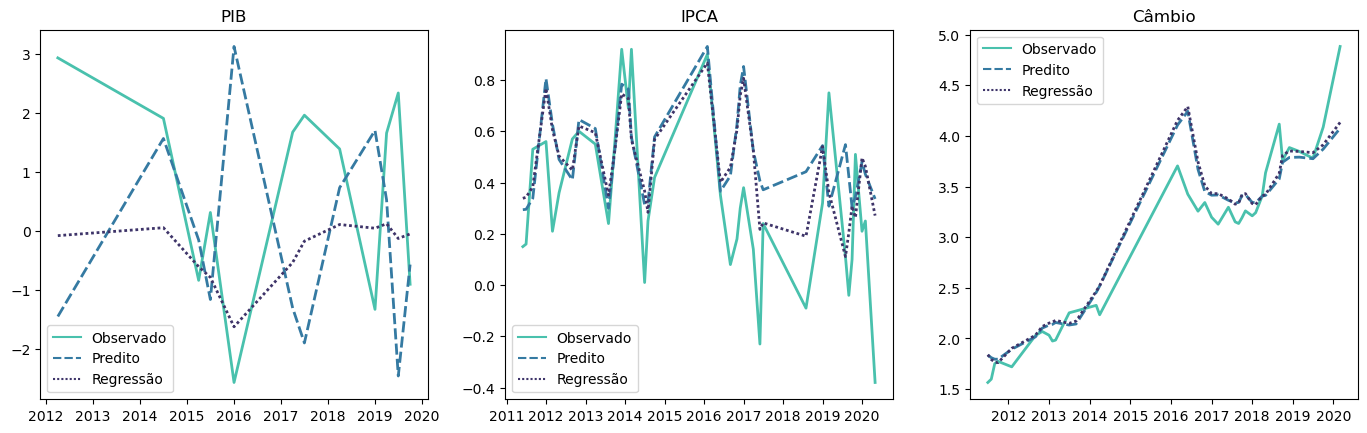

In [20]:
regpibpredict = pd.DataFrame(regpib.predict(pibx_test_int), index = pibx_test.index, columns = ["Regressão"])
regipcapredict = pd.DataFrame(regipca.predict(ipcax_test_int), index = ipcax_test.index, columns = ["Regressão"])
regcambiopredict = pd.DataFrame(regcambio.predict(cambiox_test_int), index = cambiox_test.index, columns = ["Regressão"])

fig, ax = plt.subplots(1, 3)
fig.set_figwidth(17)
sns.lineplot(data = pd.concat([piby_test, pib_pred, regpibpredict], axis = 1),
             palette = sns.color_palette("mako_r", 3), linewidth = 2, ax = ax[0]).set(title = 'PIB')
sns.lineplot(data = pd.concat([ipcay_test, ipca_pred, regipcapredict], axis = 1),
             palette = sns.color_palette("mako_r", 3), linewidth = 2, ax = ax[1]).set(title = 'IPCA')
sns.lineplot(data = pd.concat([cambioy_test, cambio_pred, regcambiopredict], axis = 1),
             palette = sns.color_palette("mako_r", 3), linewidth = 2, ax = ax[2]).set(title = 'Câmbio')

## Compilação das bases

In [21]:
with pd.ExcelWriter(path) as writer:
    pib.to_excel(writer, sheet_name = 'PIB')
    ipca.to_excel(writer, sheet_name = 'IPCA')
    cambio.to_excel(writer, sheet_name = 'Cambio')